
# Семинар: классический NLP-пайплайн (spaCy) + Zipf + правила

In [8]:
# (Colab) Установка зависимостей
!pip -q install spacy
!python -m spacy download en_core_web_sm -q


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Загрузка данных

In [9]:
from pathlib import Path


kotlovan_text = Path("Kotlovan.txt").read_text(encoding="utf-8")

print("Длина текста (символов):", len(kotlovan_text))
print(kotlovan_text[:400])


Длина текста (символов): 237812
Андрей Платонов.

                                 Котлован

    В  день  тридцатилетия  личной  жизни  Вощеву дали расчет с
небольшого механического завода, где он  добывал  средства  для
своего  существования. В увольнительном документе ему написали,
что   он   устраняется   с   производства   вследствие    роста
слабосильности в нем и задумчивости среди общего темпа труда.
    Вощев  взял  на к


## 1) Токенизация, types/tokens, частоты

In [10]:
import re
from collections import Counter

def normalize_basic(s: str, lower=True, yo_to_e=False, drop_punctuation=False):
    if yo_to_e:
        s = s.replace("ё", "е").replace("Ё", "Е")
    if lower:
        s = s.lower()
    if drop_punctuation:
        s = re.sub(r"[^А-Яа-яЁё\s]+", " ", s)
        s = re.sub(r"\s+", " ", s).strip()
    return s

versions = {
    "tokens_raw_lower": normalize_basic(kotlovan_text , lower=True, yo_to_e=False, drop_punctuation=False),
    "tokens_no_puctuation_yo_to_e": normalize_basic(kotlovan_text , lower=True, yo_to_e=True, drop_punctuation=True)
}

def tokenize_rus(s: str):
    return re.findall(r"[А-Яа-яЁё]+(?:-[А-Яа-яЁё]+)*", s)

def stats_to_tokens(tokens):
    count = Counter(tokens)
    N = sum(count.values())
    V = len(count)
    long_tail = sum(1 for f in count.values() if f <= 3)
    return count, N, V, long_tail, long_tail / V


for version_name, version_contents in versions.items():
    tokens = tokenize_rus(version_contents)
    count, N, V, long_tail, long_tail_divided = stats_to_tokens(tokens)
    print(version_name, "tokens=", N, "types=", V, "long_tail_with_types less than 4 =", long_tail, f"({long_tail_divided:.2%})")
    print("top 20:", count.most_common(20))

tokens_raw_lower tokens= 34187 types= 9808 long_tail_with_types less than 4 = 8545 (87.12%)
top 20: [('и', 1553), ('в', 879), ('не', 657), ('на', 572), ('он', 420), ('а', 419), ('что', 343), ('с', 287), ('чиклин', 284), ('его', 246), ('я', 213), ('от', 206), ('ты', 200), ('как', 199), ('но', 181), ('все', 178), ('к', 171), ('вощев', 169), ('же', 144), ('по', 143)]
tokens_no_puctuation_yo_to_e tokens= 34412 types= 9747 long_tail_with_types less than 4 = 8482 (87.02%)
top 20: [('и', 1555), ('в', 879), ('не', 657), ('на', 572), ('он', 420), ('а', 419), ('что', 379), ('с', 287), ('чиклин', 284), ('его', 246), ('я', 216), ('как', 206), ('от', 206), ('то', 204), ('ты', 200), ('но', 181), ('все', 181), ('к', 171), ('вощев', 169), ('по', 156)]


## 2) Сравните частоты **по токенам**, **по стеммам**, **по леммам**:
###    - Как меняются топ-20?
###    - Как меняется доля “длинного хвоста” (≤3) по **types**?

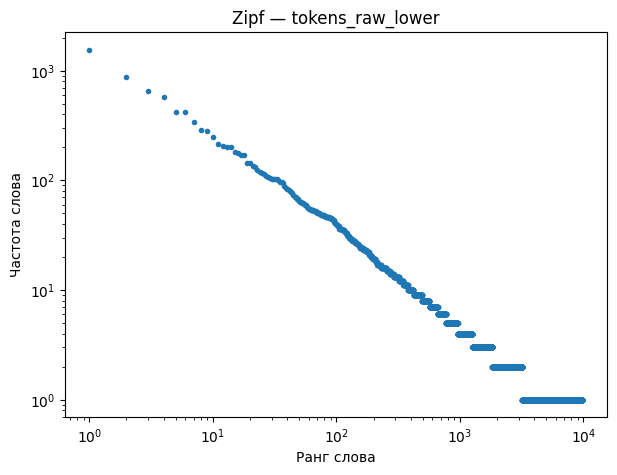

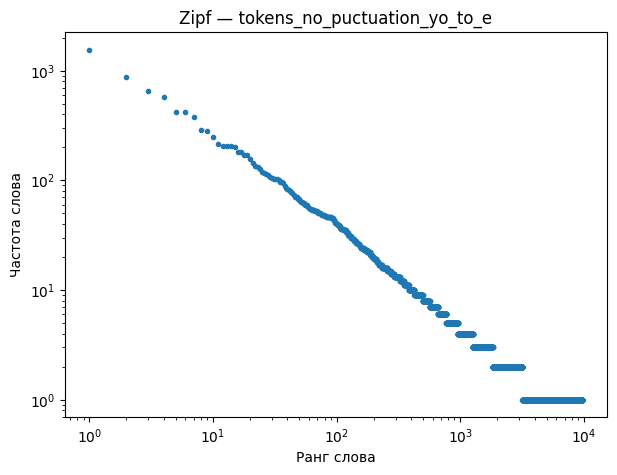

TOKENS
types: 9747 long_tail(types<=3): 8482 (87.02%)
top20: [('и', 1555), ('в', 879), ('не', 657), ('на', 572), ('он', 420), ('а', 419), ('что', 379), ('с', 287), ('чиклин', 284), ('его', 246), ('я', 216), ('как', 206), ('от', 206), ('то', 204), ('ты', 200), ('но', 181), ('все', 181), ('к', 171), ('вощев', 169), ('по', 156)]

STEMS
types: 5265 long_tail(types<=3): 3861 (73.33%)
top20: [('и', 1555), ('в', 879), ('не', 710), ('он', 597), ('на', 572), ('а', 421), ('что', 379), ('чиклин', 352), ('с', 287), ('сво', 280), ('как', 275), ('ег', 246), ('был', 235), ('я', 216), ('то', 212), ('от', 207), ('ты', 200), ('все', 194), ('эт', 183), ('но', 181)]

LEMMAS
types: 5179 long_tail(types<=3): 3845 (74.24%)
top20: [('и', 1555), ('в', 933), ('он', 848), ('не', 657), ('на', 572), ('что', 421), ('а', 419), ('быть', 376), ('чиклин', 352), ('я', 333), ('с', 331), ('она', 295), ('ты', 285), ('свой', 280), ('они', 235), ('весь', 211), ('от', 207), ('как', 206), ('то', 204), ('человек', 202)]



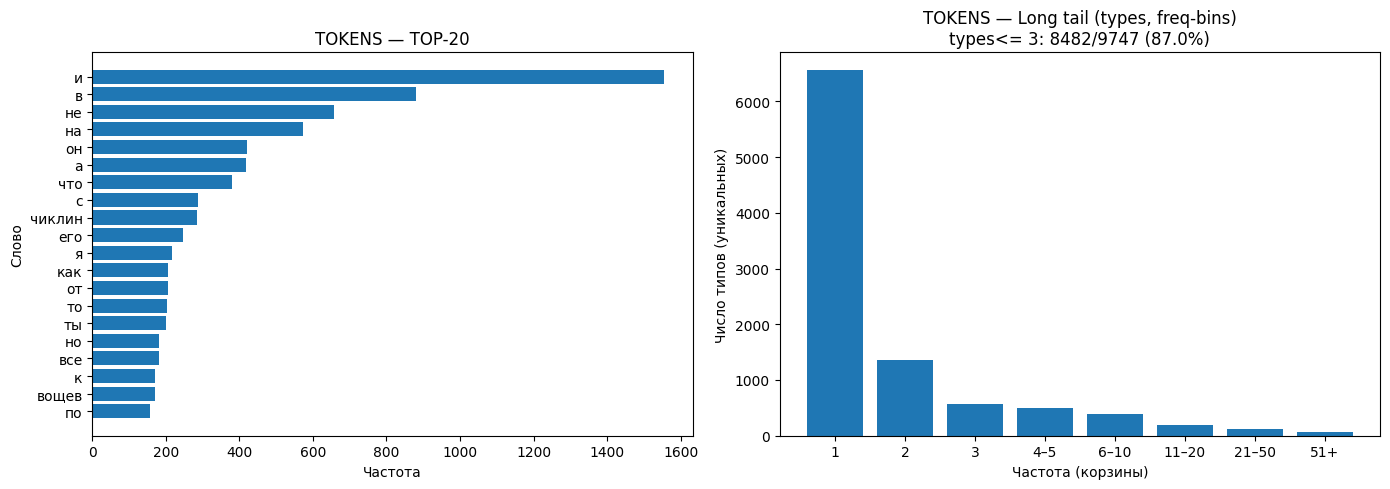

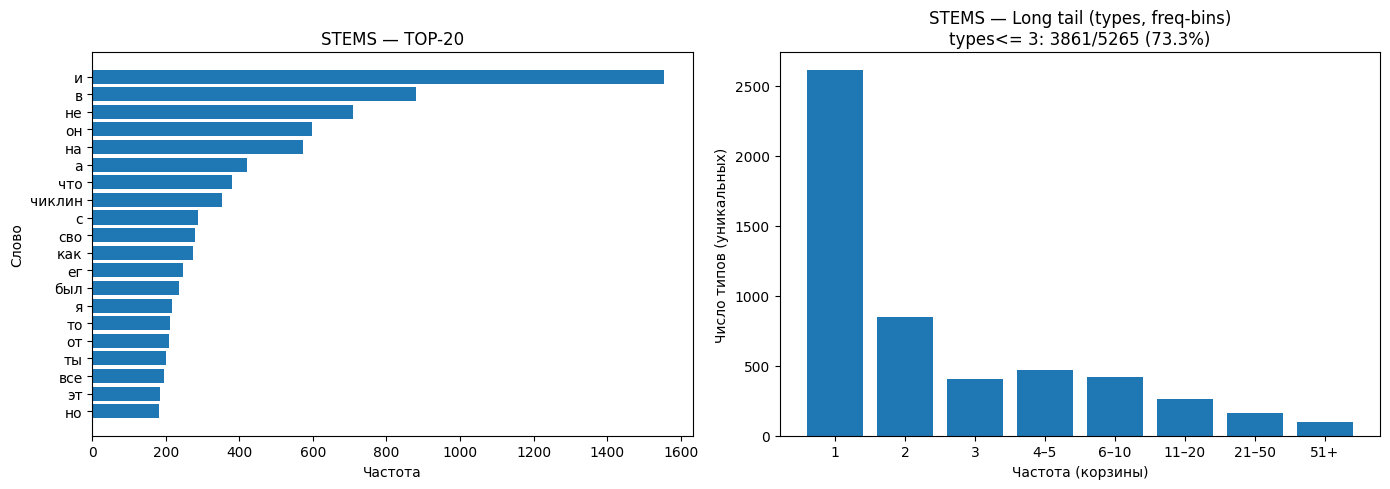

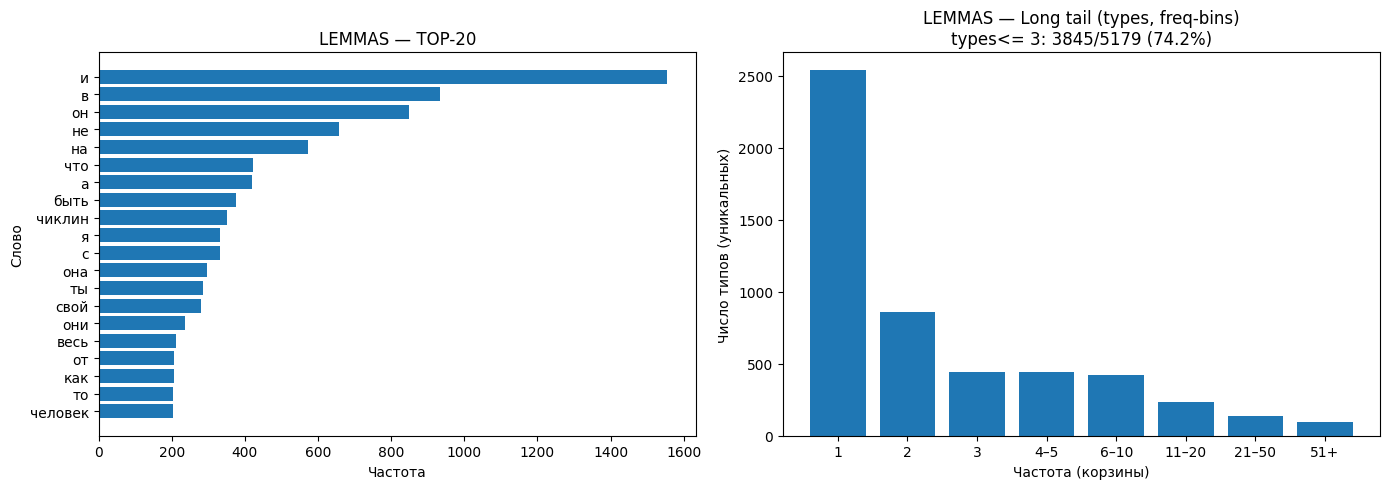

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


def plot_zipf(cnt, title):
    freqs_sorted = np.array(sorted(cnt.values(), reverse=True))
    ranks = np.arange(1, len(freqs_sorted) + 1)
    plt.figure(figsize=(7,5))
    plt.loglog(ranks, freqs_sorted, marker=".", linestyle="none")
    plt.title(title)
    plt.xlabel("Ранг слова")
    plt.ylabel("Частота слова")
    plt.show()

for name, s in versions.items():
    toks = tokenize_rus(s)
    cnt = Counter(toks)
    plot_zipf(cnt, f"Zipf — {name}")    

base_tokens = tokenize_rus(versions["tokens_no_puctuation_yo_to_e"])



import nltk
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian")
stems = [stemmer.stem(w) for w in base_tokens]

import pymorphy3
morph = pymorphy3.MorphAnalyzer()
lemmas = [morph.parse(w)[0].normal_form for w in base_tokens]

def report(name, items):
    cnt = Counter(items)
    lt = sum(1 for f in cnt.values() if f <= 3)
    print(name)
    print("types:", len(cnt), "long_tail(types<=3):", lt, f"({lt/len(cnt):.2%})")
    print("top20:", cnt.most_common(20))
    print()

# токены, корни и леммы текстом
report("TOKENS", base_tokens)
report("STEMS", stems)
report("LEMMAS", lemmas)


def plot_top20_vs_tail(items, title, tail_threshold=3):
    cnt = Counter(items)

    top = cnt.most_common(20)
    words = [w for w, _ in top][::-1]  
    freqs = [f for _, f in top][::-1]


    freqs_all = np.array(list(cnt.values()))
    tail_types = int((freqs_all <= tail_threshold).sum())
    total_types = len(cnt)
    tail_share = tail_types / total_types if total_types else 0.0

    bins_labels = ["1", "2", "3", "4–5", "6–10", "11–20", "21–50", "51+"]
    bins_counts = [
        np.sum(freqs_all == 1),
        np.sum(freqs_all == 2),
        np.sum(freqs_all == 3),
        np.sum((freqs_all >= 4) & (freqs_all <= 5)),
        np.sum((freqs_all >= 6) & (freqs_all <= 10)),
        np.sum((freqs_all >= 11) & (freqs_all <= 20)),
        np.sum((freqs_all >= 21) & (freqs_all <= 50)),
        np.sum(freqs_all >= 51),
    ]

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].barh(words, freqs)
    ax[0].set_title(f"{title} — TOP-20")
    ax[0].set_xlabel("Частота")
    ax[0].set_ylabel("Слово")

    ax[1].bar(bins_labels, bins_counts)
    ax[1].set_title(f"{title} — Long tail (types, freq-bins)\n"
                    f"types<= {tail_threshold}: {tail_types}/{total_types} ({tail_share:.1%})")
    ax[1].set_xlabel("Частота (корзины)")
    ax[1].set_ylabel("Число типов (уникальных)")

    plt.tight_layout()
    plt.show()

#графики для токенов, корней и лемм
plot_top20_vs_tail(base_tokens, "TOKENS")
plot_top20_vs_tail(stems, "STEMS")
plot_top20_vs_tail(lemmas, "LEMMAS")


## 3) Выберите 5 предложений и сравните:
###    - POS/DEP/NER от `spaCy`
###    - леммы от `pymorphy3`

In [14]:
import spacy

nlp_ru = spacy.load("ru_core_news_sm")
doc = nlp_ru(kotlovan_text)

# без него потом слова не ловятся
if "sentencizer" not in nlp_ru.pipe_names:
    nlp_ru.add_pipe("sentencizer", first=True) 

sents = [s.text.strip() for s in doc.sents if s.text.strip()]
sample_sents = sents[:5]

import pandas as pd

def analyze_sentence(sent):
    d = nlp_ru(sent)
    rows = []
    for t in d:
        if t.is_space:
            continue
        lemma_pym = morph.parse(t.text)[0].normal_form if re.search(r"[А-Яа-яЁё]", t.text) else t.text
        ent = ""
        if t.ent_iob_ != "O":
            ent = f"{t.ent_iob_}-{t.ent_type_}"
        rows.append([t.text, t.lemma_, lemma_pym, t.pos_, t.dep_, ent])
    return pd.DataFrame(rows, columns=["token","lemma_spacy","lemma_pymorphy3","POS","DEP","ENT"])

for s in sample_sents:
    print(s)
    display(analyze_sentence(s))



Андрей Платонов.


,token,lemma_spacy,lemma_pymorphy3,POS,DEP,ENT
0,Андрей,андрей,андрей,PROPN,ROOT,B-PER
1,Платонов,платонов,платонов,PROPN,appos,I-PER
2,.,.,.,PUNCT,punct,


Котлован

    В  день  тридцатилетия  личной  жизни  Вощеву дали расчет с
небольшого механического завода, где он  добывал  средства  для
своего  существования.


,token,lemma_spacy,lemma_pymorphy3,POS,DEP,ENT
0,Котлован,котлован,котлован,PROPN,nsubj,
1,В,в,в,ADP,case,
2,день,день,день,NOUN,nmod,
3,тридцатилетия,тридцатилетия,тридцатилетие,NOUN,nmod,
4,личной,личный,личный,ADJ,amod,
5,жизни,жизнь,жизнь,NOUN,nmod,
6,Вощеву,вощеву,вощева,PROPN,appos,B-PER
7,дали,дать,дать,VERB,ROOT,
8,расчет,расчёт,расчёт,NOUN,obj,
9,с,с,с,ADP,case,


В увольнительном документе ему написали,
что   он   устраняется   с   производства   вследствие    роста
слабосильности в нем и задумчивости среди общего темпа труда.


,token,lemma_spacy,lemma_pymorphy3,POS,DEP,ENT
0,В,в,в,ADP,case,
1,увольнительном,увольнительный,увольнительный,ADJ,amod,
2,документе,документ,документ,NOUN,obl,
3,ему,ему,он,PRON,iobj,
4,написали,написать,написать,VERB,ROOT,
5,",",",",",",PUNCT,punct,
6,что,что,что,SCONJ,mark,
7,он,он,он,PRON,nsubj,
8,устраняется,устраняться,устраняться,VERB,ccomp,
9,с,с,с,ADP,case,


Вощев  взял  на квартире вещи в мешок и вышел наружу, чтобы
на воздухе лучше понять  свое  будущее.


,token,lemma_spacy,lemma_pymorphy3,POS,DEP,ENT
0,Вощев,вощев,вощев,PROPN,obj,
1,взял,взять,взять,VERB,ROOT,
2,на,на,на,ADP,case,
3,квартире,квартира,квартира,NOUN,obl,
4,вещи,вещь,вещь,NOUN,obj,
5,в,в,в,ADP,case,
6,мешок,мешок,мешок,NOUN,obl,
7,и,и,и,CCONJ,cc,
8,вышел,выйти,выйти,VERB,conj,
9,наружу,наружу,наружу,ADV,advmod,


Но  воздух  был  пуст,
неподвижные  деревья  бережно  держали жару в листьях, и скучно
лежала пыль  на  безлюдной  дороге  -  в  природе  было  такое
положение.


,token,lemma_spacy,lemma_pymorphy3,POS,DEP,ENT
0,Но,но,но,CCONJ,cc,
1,воздух,воздух,воздух,NOUN,nsubj,
2,был,быть,быть,AUX,cop,
3,пуст,пустой,пустой,ADJ,ROOT,
4,",",",",",",PUNCT,punct,
5,неподвижные,неподвижный,неподвижный,ADJ,amod,
6,деревья,дерево,дерево,NOUN,nsubj,
7,бережно,бережно,бережно,ADV,advmod,
8,держали,держать,держать,VERB,conj,
9,жару,жара,жара,NOUN,obj,


## 4) Составьте список имен персонажей

In [ ]:
from collections import Counter
from IPython.display import display

_re_clean = re.compile(r"[А-Яа-яЁё]+(?:-[А-Яа-яЁё]+)*")

def normalize_name_ru(text: str) -> str | None:
    m = _re_clean.search(text)
    if not m:
        return None
    w = m.group(0)
    nf = morph.parse(w)[0].normal_form
    return nf.capitalize()

def find_names(doc: str):
    propn_norm = []
    for t in doc:
        if t.pos_ == "PROPN":
            n = normalize_name_ru(t.text)
            if n:
                propn_norm.append(n)
    return propn_norm

display(("Имена в 'Котловане'", Counter(find_names(doc)).most_common(30)))


# в первой книге не очень много нашлось имён собственных и приветствий, добавил вторую для сравнения
alternative_text = Path("Kruz_Zemlya_lischnih.txt").read_text(encoding="utf-8")
doc_alternative_text = nlp_ru(alternative_text)
display(("Имена в 'Земле лишних'", Counter(find_names(doc_alternative_text)).most_common(30)))


("Имена в 'Котловане'",
 [('Чиклин', 339),
  ('Вощев', 159),
  ('Жачёв', 80),
  ('Козлов', 77),
  ('Настя', 76),
  ('Сафронов', 69),
  ('Елисей', 64),
  ('Пашкин', 57),
  ('Прушевский', 54),
  ('Вощева', 39),
  ('Жачева', 21),
  ('А', 18),
  ('Оргдвор', 18),
  ('Активист', 10),
  ('Барак', 9),
  ('Поп', 9),
  ('Мочь', 7),
  ('Девочка', 7),
  ('Двор', 7),
  ('Миша', 6),
  ('Говорить', 6),
  ('Никита', 6),
  ('Юлия', 6),
  ('Ленин', 6),
  ('Колхоз', 6),
  ('Наст', 6),
  ('Я', 5),
  ('Молотобоец', 5),
  ('Дать', 4),
  ('Ты', 4)])

("Имена в 'Земле лишних'",
 [('Мария', 211),
  ('Пилар', 193),
  ('Немцов', 130),
  ('Джей', 114),
  ('Джо', 106),
  ('Орден', 100),
  ('Бонит', 89),
  ('Земля', 81),
  ('Аламо', 77),
  ('Зимин', 71),
  ('Барабан', 67),
  ('Михаил', 62),
  ('Техас', 56),
  ('Нью', 54),
  ('Владимирский', 54),
  ('Лукас', 54),
  ('Франко', 51),
  ('Порто', 51),
  ('Свет', 47),
  ('Силаев', 45),
  ('Игорь', 44),
  ('Рино', 44),
  ('Армия', 44),
  ('А', 42),
  ('Россия', 42),
  ('Андрей', 40),
  ('Москва', 39),
  ('Быхов', 37),
  ('Территория', 31),
  ('Николай', 31)])

## 5) Найдите как можно больше предложений, где здороваются

In [ ]:

from spacy.matcher import Matcher

matcher_ru = Matcher(nlp_ru.vocab)

pattern_greet = [
    [{"TEXT": {"REGEX": r"(?i)^(?:здравствуйте|здравствуй|привет|приветствую)\b"}}],
    [{"TEXT": {"REGEX": r"(?i)^здраст(?:е|и)\b"}}],
    [{"LOWER": "добрый"}, {"LOWER": "день"}],
]

matcher_ru.add("GREET_RU", pattern_greet)

def detect_greeting_sentences_anywhere(text):
    doc = nlp_ru(text)
    hits = []
    for sent in doc.sents:
        if matcher_ru(sent):
            hits.append(sent.text)
    return hits

greet_sents = detect_greeting_sentences_anywhere(kotlovan_text) 
display("Котлован", len(greet_sents), greet_sents[:20])

# вторая
alternative_greet_sents = detect_greeting_sentences_anywhere(alternative_text) 
display("Земля лишних", len(alternative_greet_sents), alternative_greet_sents[:20])

# ещё одна, третья, книга, для сравнения
dialogi = Path("Dialogi_na_angliyskom_dlya_realnogo_obschenia.txt").read_text(encoding="utf-8")
dialogi_greet_sents = detect_greeting_sentences_anywhere(dialogi) 
display("Диалоги для реального общения", len(dialogi_greet_sents), dialogi_greet_sents[:120])


'Котлован'

6

['\n    -  Как  урод я только приветствую ваше мнение, а помочь не\nмогу,- сказал Жачев.- Вам ведь так и так все  равно  погибать\n-  у  вас  же в сердце не лежит ничто, лучше любите что-нибудь\nмаленькое живое и отравливайте себя  трудом.',
 '\n    Привет бедному колхозу, а кулакам нет".',
 '\n    - Здравствуй, товарищ актив!- сказали они все сразу.',
 '\n    - Привет кадру!- ответил задумчиво активист и  постоял  в\nмолчаливом  соображении.-  А  теперь  мы  повторим  букву "а",\nслушайте мои сообщения и пишите...\n    Женщины прилегли к полу, потому что вся изба-читальня  была\nпорожняя, и стали писать кусками штукатурки на досках.',
 '\n    - Здравствуйте!- сказал он колхозу,  обрадовавшись.-  Вы\nстали теперь, как я, я тоже ничто.',
 '\n    - Здравствуй!- обрадовался весь колхоз одному человеку.']

'Земля лишних'

18

['\n     - Здравствуйте, - поприветствовала она меня. -',
 '\n     - Здравствуйте, - поздоровался я в ответ. -',
 '\n     - Здравствуйте, чего вы хотели? -',
 '\n     - Привет, я Андрей, - привстал я, пожимая протянутую руку.',
 '\n     Заговорил "кенвуд" голосом Джейми:\n     - Кхм...  привет...  у  нас  проблема,   по-моему...   Мы   во   что-то\nврезались...\n     - Да, я вижу, - согласился с его заявлением я.',
 '\n     - Добрый день.',
 '\n     - Привет, Джо! -',
 '\n     - Привет,  капитан.',
 '\n     - Привет, - обратился я к этой представительной даме. -',
 '\n     - Здравствуйте, Сергей Геннадьевич.',
 '\n     - Здравствуйте, Ярцев,  -  ответил  командир  и  указал  на  кресло:  -\nПрисаживайтесь.',
 ' Он  приветственно  взмахнул  рукой  и\nспросил:\n     - Добрый день!',
 '\n     - Добрый день.',
 'Видимо, теперь  стало\nможно здороваться, и Дейв сказал: "Привет".',
 '\n     С заднего двора зашли остальные бородачи, увидев меня, тоже  подошли  к\nхолодильнику, достали по буты

'Диалоги на все случаи жизни'

108

['Привет!',
 'Привет!',
 'Привет!',
 'Привет!',
 'Привет!',
 'Привет!',
 'Привет, Сара!',
 'Привет, Ник!',
 'Привет, Пэм!',
 'Привет!',
 'Привет, Пол!',
 'Привет!',
 'Привет!',
 'Привет, Питер!',
 'Привет!',
 'Здравствуйте!',
 'Привет!',
 'Привет!',
 'Привет!',
 'Привет!',
 'Привет!',
 'Привет!',
 'Привет!',
 'Привет!',
 'Привет!',
 'Привет!',
 'Привет!',
 'Здравствуйте!',
 'Привет, Джон!',
 'Здравствуйте!',
 'Здравствуйте!',
 'Здравствуйте!',
 'Здравствуйте!',
 '94 Диалоги на английском для реального общения\n\nЗдравствуйте!',
 'Здравствуйте!',
 'Здравствуйте!',
 'Здравствуйте!',
 'Здравствуйте!',
 'Здравствуйте!',
 'Здравствуйте!',
 'Здравствуйте!',
 'Здравствуйте!',
 'Здравствуйте!',
 'Здравствуйте!',
 'Здравствуйте!',
 'Здравствуйте!',
 'Здравствуйте!',
 'Здравствуйте, сэр.',
 'Здравствуйте!',
 'Здравствуйте!',
 'Здравствуйте!',
 'Здравствуйте!',
 'Здравствуйте!',
 'Здравствуйте!',
 'Здравствуйте!',
 '\n\nЗдравствуйте!',
 'Здравствуйте!',
 '\n\nПривет!',
 'Привет!',
 'Здравствуйте,